<a href="https://colab.research.google.com/github/MarkoHaralovic/DL_cyber_attacks/blob/main/notebooks/data_poisoning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torchvision
from torchvision.models import efficientnet_b0
from torchvision.models import resnet18
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


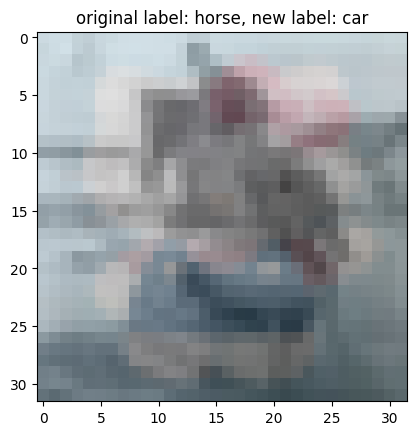

In [3]:
poisoned_image_class = "airplane"

root_dir = './drive/MyDrive/data_poisoning/'

poisoned_trainset_imgs, poisoned_trainset_targets = np.load(root_dir + 'train_images.npy'), np.load(root_dir + 'train_targets.npy')
poisoned_testset_imgs, poisoned_testset_targets = np.load(root_dir + 'test_images.npy'), np.load(root_dir + 'test_targets.npy')

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

index = random.randint(0, len(poisoned_testset_targets) - 1)

plt.imshow(poisoned_testset_imgs[index])
plt.title(f"original label: {classes[poisoned_testset_targets[index][0]]}, new label: {classes[poisoned_testset_targets[index][1]]}")
plt.show()

In [4]:
if not torch.cuda.is_available():
  print("Please set GPU via: Edit -> Notebook Settings")
else:
  print("GPU is found!")

device = "cuda" if torch.cuda.is_available() else "cpu"

GPU is found!


### Training the model(s)

In [5]:
from torchvision.transforms import v2
from PIL import Image

# function to transfrom images used for efficientnet_b0 and resnet18

def transform_images(images, model_name="efficientnet_b0", test=False):
  if not test:
    transform = v2.Compose([
                    v2.RandomResizedCrop((224, 224), antialias=True),
                    v2.RandomVerticalFlip(p=0.1),
                    v2.RandomHorizontalFlip(p=0.1)
                  ])
  else:
    transform = v2.Resize(224)
  permutation = [0, 3, 1, 2]

  if model_name == "resnet18":
    transform = v2.Compose([
                    transform,
                    v2.ToTensor(),
                    v2.Normalize(std=(0.5, 0.5, 0.5), mean=(0.5, 0.5, 0.5))
                ])
    permutation = [0, 1, 2, 3]

  transformed_imgs = np.array(
                  [np.array(transform(Image.fromarray((img * 255).astype('uint8')))) for img in images]
                    ).astype("float32")
  transformed_imgs = torch.from_numpy(transformed_imgs)
  return transformed_imgs.permute(permutation)


In [10]:
# training function used both for efficientnet_b0 and for resnet18

def train(model, model_name, optimizer, criterion=nn.CrossEntropyLoss(), epochs=4, batch_size=32):
  max_acc = 0.0
  model.train()
  for epoch in range(epochs):
    total_loss = 0.0
    total_correct = 0
    total_size = 0
    model.train()
    for index in range(0, len(poisoned_trainset_targets), batch_size):
        data, target = poisoned_trainset_imgs[index : index + batch_size], poisoned_trainset_targets[index : index + batch_size]
        # we are transforming the images right before forward propagation in order to use less ram in the colab runtime!
        data, target = transform_images(data, model_name), torch.from_numpy(target[:, 1])
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_correct += (predicted == target).sum().item()
        total_size += data.size(0)
        loss.backward()
        optimizer.step()
        if index % 600 == 0:
            print(
                "Train Epoch: {} Average loss: {:.6f}".format(
                    epoch,
                    total_loss / total_size,
                )
            )

    epoch_loss = total_loss / total_size
    epoch_acc = 100.0 * (total_correct / total_size)
    print(f"Accuracy for epoch: {epoch} is {epoch_acc} %")
    if(epoch_acc > max_acc):
      max_acc = epoch_acc
      save_model = deepcopy(model.state_dict())
      print(f"\tnew save_model is {model_name} with accuracy: {epoch_acc} %")

In [ ]:
# run this in order to train efficientnet

model = efficientnet_b0().to(device)
if os.path.isfile("./curr_model.pt"):
  model.load_state_dict(torch.load("./curr_model.pt"))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train(model, "efficientnet_b0", optimizer, epochs=1)

In [47]:
# run this in order to train resnet18

model = resnet18().to(device)
if os.path.isfile("./curr_model.pt"):
  model.load_state_dict(torch.load("./curr_model.pt"))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train(model, "resnet18", optimizer, epochs=5)

OutOfMemoryError: ignored

In [16]:
# run this if you are satisfied with the current model and you want to save it
save_path = "./curr_model.pt"
torch.save(save_model, save_path)

### Testing the model(s)

In [45]:
# generic test function used both for backdoored and benign testsets
def test(testset, labels, model, model_name, batch_size=16):
  total_count = len(labels)
  total_correct = 0

  model.eval()
  testset, labels = np.array_split(testset, batch_size), np.array_split(labels, batch_size)
  for imgs, labels in zip(testset, labels):
    img = transform_images(imgs, model_name, test=True).to(device)
    out = model(img)
    _, predicted = torch.max(out.data, 1)
    print(predicted)
    total_correct += (predicted == labels).sum().item()

  return 100.0 * total_correct / total_count

In [22]:
# define the model before performing the tests below:

# model = efficientnet_b0.to(device)
# model_name = "efficientnet_b0"

model = resnet18().to(device)
model_name = "resnet18"

if os.path.isfile("./curr_model.pt"):
  model.load_state_dict(torch.load("./curr_model.pt"))

In [46]:
# test our model on some backdoored images
if os.path.isfile("./curr_model.pt"):
  model.load_state_dict(torch.load("./curr_model.pt"))

backdoor_acc = test(poisoned_testset_imgs, poisoned_testset_targets[:, 1], model, model_name)
print(f"model accuracy for backdoored data: {backdoor_acc} %")

OutOfMemoryError: ignored

In [ ]:
from torchvision.datasets import CIFAR10
from torchvision import transforms

# perform tests on benign testset
model = efficientnet_b0().to(device)
if os.path.isfile("./curr_model.pt"):
  model.load_state_dict(torch.load("./curr_model.pt"))

benign_testset = CIFAR10(root="./data", train=False, download=True)
benign_acc = test(benign_testset.data, benign_testset.targets, model, "efficientnet_b0")
print(f"model accuracy for benign data: {benign_acc} %")

Files already downloaded and verified
model accuracy for benign data: 80.21 %
